* Testing curvature
first, we load the cartoonlike package, which is a simple way of 
creating curves. Here we create a family of curves with curvature 
varying from a positive value to a negative value

┌ Info: Building the CUDAnative run-time library for your sm_61 device, this might take a while...
└ @ CUDAnative /home/dsweber/.julia/packages/CUDAnative/LkH1v/src/compiler/rtlib.jl:168
┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/dsweber/.julia/packages/GPUArrays/J4c3Q/src/indexing.jl:16


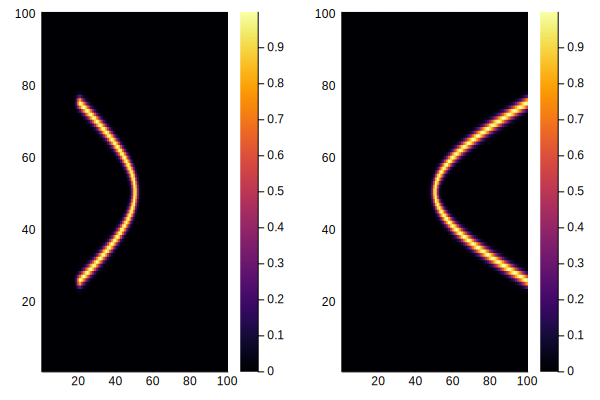

In [4]:
using Revise
using CUDA, Zygote, Plots, cartoonLike, FFTW, LinearAlgebra
nPoints = 5
curveExamples = distinguishing_curvature(nPoints)
curveExamples = cu(reshape(curveExamples, (size(curveExamples)[1:2]..., 1,
                                        size(curveExamples, 3))));
plot(heatmap(curveExamples[:,:,1,3]), heatmap(curveExamples[:,:,1,11]), layout=(1,2))

Now that we have a collection of test images, lets see what a collating layers
does. We'll consider just the first channel, since initially every channel is just
random sums of each frame element

In [5]:
using collatingTransform, Flux
stack = collatingLayer(size(curveExamples)[1:2]..., 1=>16, scales=4,
                       batchSize=size(curveExamples,4))
@time oneLayered = stack(curveExamples);

┌ Info: Recompiling stale cache file /home/dsweber/.julia/compiled/v1.2/collatingTransform/PXxUx.ji for collatingTransform [c8865cad-479e-4e1b-9832-8b458869fd32]
└ @ Base loading.jl:1240


ERROR: 

LoadError: 

ArgumentError: Package Flux does not have CUDAapi in its dependencies:
- If you have Flux checked out for development and have
  added CUDAapi as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with Flux
Stacktrace:


 [1] require(::

Module, ::Symbol) at ./loading.jl:889
 [2] include at ./boot.jl:328 [inlined]
 [3] include_relative(::Module, ::String) at ./loading.jl:1094
 [4] include(::Module, ::String) at ./Base.jl:31
 [5] top-level scope at none:2
 [6] eval at ./boot.jl:330 [inlined]
 [7] eval(::Expr) at ./client.jl:432
 [8] top-level scope at ./none:3
in expression starting at /home/dsweber/.julia/dev/Flux/src/Flux.jl:23


ERROR: 

LoadError: 

Failed to precompile Flux [587475ba-b771-5e3f-ad9e-33799f191a9c] to /home/dsweber/.julia/compiled/v1.2/Flux/QdkVy.ji.


Stacktrace:
 [1] error

(::String) at ./error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at ./loading.jl:1253
 [3] _require(::Base.PkgId) at ./loading.jl:1013
 [4] require(::Base.PkgId) at ./loading.jl:911
 [5] require(::Module, ::Symbol) at ./loading.jl:906
 [6] include at ./boot.jl:328 [inlined]
 [7] include_relative(::Module, 

::String) at ./loading.jl:1094
 [8] include(::Module, ::String) at ./Base.jl:31
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:330 [inlined]
 [11] eval(::Expr) at ./client.jl:432
 [12] top-level scope at ./none:3
in expression starting at /home/dsweber/allHail/projects/collatingTransform/src/collatingTransform.jl:11


ErrorException: Failed to precompile collatingTransform [c8865cad-479e-4e1b-9832-8b458869fd32] to /home/dsweber/.julia/compiled/v1.2/collatingTransform/PXxUx.ji.

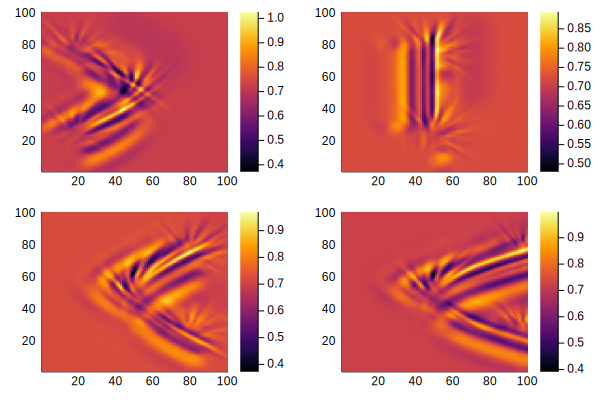

In [6]:
plot(heatmap(CuArray(oneLayered[:,:,1,3])), heatmap(CuArray(oneLayered[:,:,1,6])), heatmap(CuArray(oneLayered[:,:,1,9])), heatmap(CuArray(oneLayered[:,:,1,11])), layout=(2,2))

You can more or less make out the original curves. But this is no different
than doing one dense layer on the output with random weights. Here's an example
after a couple of untrained layers.

In [4]:
stack = Chain(collatingLayer(size(curveExamples)[1:2]..., 1=>16, batchSize=11),
              collatingLayer(size(curveExamples)[1:2]..., 16=>27, batchSize=11),
              MaxPool((2,2)),
              collatingLayer(50,50, 27=>16, batchSize=11))
@time transformed = stack(curveExamples);
size(transformed)

┌ Warning: The specified Shearlet system was not available for data of size 100x100. Filters were automatically set to configuration 5 (see operations.jl).
└ @ Shearlab /home/dsweber/.julia/packages/Shearlab/Enh5c/src/util/operations.jl:258
┌ Warning: The specified Shearlet system was not available for data of size 100x100. Filters were automatically set to configuration 5 (see operations.jl).
└ @ Shearlab /home/dsweber/.julia/packages/Shearlab/Enh5c/src/util/operations.jl:258


┌ Warning: The specified Shearlet system was not available for data of size 50x50. Filters were automatically set to configuration 7 (see operations.jl).
└ @ Shearlab /home/dsweber/.julia/packages/Shearlab/Enh5c/src/util/operations.jl:258


  2.795088 seconds (3.70 M allocations: 1.242 GiB, 32.20% gc time)


(50, 50, 16, 11)

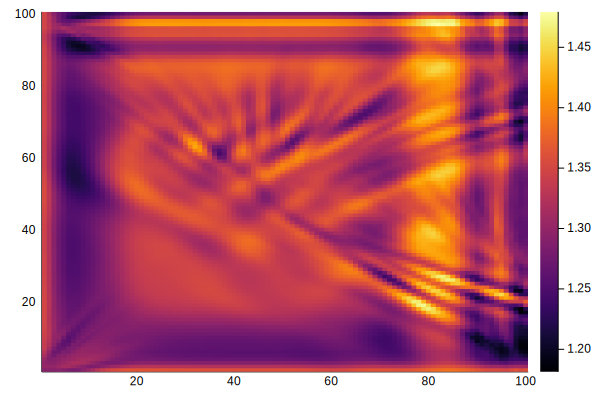

In [65]:
heatmap(transformed[:,:,5,11])

Without any training, we're just getting a random blurring of the
coefficients. We don't have classes really in this example, but we do have a
regression problem of sorts. What we want to do is maximize the sparsity while
still being able to distinguish the curvature. If we denote the last layer
collating layer by c, and the curvature \kappa, one way of doing this is
\begin{center}
\min \|c\|_1 + \sum_{i=1}
\end{center}

In [12]:
using Flux: mse
κ = cu(range(-10, 10, length=11))
# stack = Chain(collatingLayer(size(curveExamples)[1:2]..., 1=>16, batchSize=11),
#               collatingLayer(size(curveExamples)[1:2]..., 16=>27, batchSize=11),
#               MaxPool((2,2))|>gpu,
#               collatingLayer(50,50, 27=>16, batchSize=11),
#               (x) -> reshape(x[21:30, 21:30,:,:], (10*10*16, :)),
#               Dense(10*10*16,1)|>gpu)
stack = Chain(collatingLayer(size(curveExamples)[1:2]..., 1=>16, batchSize=11,
                             trainable=false)...,
              (x) -> reshape(x, (100*100*16, size(x)[end])),
              Dense(100*100*16,1)|>gpu)
#penalty() = norm(stack.)
function loss(x, y)
    #activ = Flux.activations(stack, x)
    return mse(stack(x), y)#mse(activ[end], y)# + norm(activ[4], 1)/norm(x,2)
end
loss(curveExamples, κ)

┌ Warning: The specified Shearlet system was not available for data of size 100x100. Filters were automatically set to configuration 5 (see operations.jl).
└ @ Shearlab /home/dsweber/.julia/packages/Shearlab/Enh5c/src/util/operations.jl:258


440.0258860601647

In [24]:
Flux.train!(loss, params(stack), [(curveExamples,κ)], ADAM())
#@doc Zygote.Core._apply

MethodError: MethodError: no method matching findmax(::Tuple{Int64,Int64}; dims=Colon())
Closest candidates are:
  findmax(::Any) at array.jl:2065 got unsupported keyword argument "dims"
  findmax(!Matched::BitArray) at bitarray.jl:1523 got unsupported keyword argument "dims"
  findmax(!Matched::SparseArrays.SparseMatrixCSC) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/SparseArrays/src/sparsematrix.jl:1928 got unsupported keyword argument "dims"
  ...

In [17]:
dumb = Chain(Dense(100,30,relu), Dense(30,20, relu), Dense(20,1, relu), softmax) |> gpu
dumex = cu(randn(100,11));
function loss(x,y)
    return mse(dumb(x), y)
end
dumb(dumex)
loss(dumex,κ)
Flux.train!(loss, params(dumb), (dumex, κ), ADAM())

MethodError: MethodError: no method matching loss(::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32, ::Float32)
Closest candidates are:
  loss(::Any, ::Any) at In[17]:4

In [ ]:
@doc fftshift

In [23]:
@doc max

  max(x, y, ...)

  Return the maximum of the arguments. See also the maximum function to take
  the maximum element from a collection.

  Examples
  ≡≡≡≡≡≡≡≡≡≡

  julia> max(2, 5, 1)
  5